In [2]:
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt

# Your trading data is stored in the string below (replace with your file path if needed)
trading_data = '''R2010 bought 1,076 Yes at 11.0¢ ($118)

1d ago

R2010 sold 2,035 Yes at 10.0¢ ($204)

1d ago

simpleman sold 2,817 No at 88.6¢ ($2,496)

2d ago
'''  # This is just a small sample - you'll use your full data

# Parse the trading data
def parse_data(text_content):
    # Clean the input if needed
    if text_content.startswith("'") and text_content.endswith("'"):
        text_content = text_content[1:-1]
    
    lines = text_content.strip().split('\n')
    parsed_data = []
    
    i = 0
    transaction = {}
    
    while i < len(lines):
        line = lines[i].strip()
        
        if not line:  # Skip empty lines
            i += 1
            continue
        
        # Check if this is a transaction line
        if 'bought' in line or 'sold' in line:
            action = 'bought' if 'bought' in line else 'sold'
            action_index = line.index(action)
            
            # Parse user name
            user = line[:action_index].strip()
            
            # Parse quantity and type
            quantity_match = re.search(r'(\d+,?\d*)\s+(Yes|No)', line)
            if not quantity_match:
                i += 1
                continue
                
            quantity = int(quantity_match.group(1).replace(',', ''))
            type_ = quantity_match.group(2)
            
            # Parse price
            price_match = re.search(r'at\s+(\d+\.?\d*)¢', line)
            if not price_match:
                i += 1
                continue
                
            price = float(price_match.group(1)) / 100  # Convert cents to dollars
            
            # Parse amount
            amount_match = re.search(r'\(\$(\d+,?\d*)\)', line)
            if not amount_match:
                i += 1
                continue
                
            amount = float(amount_match.group(1).replace(',', ''))
            
            transaction = {
                'user': user,
                'action': action,
                'quantity': quantity,
                'type': type_,
                'price': price,
                'amount': amount
            }
        
        # Check for date line
        elif 'd ago' in line or 'mo ago' in line:
            if transaction:  # Only process if we have a transaction
                # Parse date
                date = datetime.now()
                if 'd ago' in line:
                    days_ago = int(line.split('d')[0].strip())
                    date = date - timedelta(days=days_ago)
                elif 'mo ago' in line:
                    months_ago = int(line.split('mo')[0].strip())
                    date = date - timedelta(days=months_ago * 30)
                
                transaction['date'] = date.strftime('%Y-%m-%d')
                parsed_data.append(transaction)
                transaction = {}  # Reset for next transaction
        
        i += 1
    
    return parsed_data

# Parse the data from your file
with open("$100_bets.txt", "r") as file:
    text_content = file.read()

data = parse_data(text_content)

# Check if we have data
if not data:
    print("No valid trading data found")
else:
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    # Calculate volume by date and type
    volume_by_type = df.groupby(['date', 'type'])['amount'].sum().unstack(fill_value=0)
    
    # Ensure both Yes and No columns exist
    if 'Yes' not in volume_by_type.columns:
        volume_by_type['Yes'] = 0
    if 'No' not in volume_by_type.columns:
        volume_by_type['No'] = 0
    
    # Calculate total volume
    volume_by_type['Total'] = volume_by_type['Yes'] + volume_by_type['No']
    
    # Display the results
    print(f"Total transactions: {len(data)}")
    print("\nVolume over time:")
    print(volume_by_type)
    
    # Save to CSV
    volume_by_type.to_csv("volume_over_time.csv")
    
    # Calculate top traders
    top_traders = df.groupby('user')['amount'].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 traders by volume:")
    print(top_traders)
    
    # Save top traders to CSV
    top_traders.to_csv("top_traders.csv")

Total transactions: 599

Volume over time:
type             No      Yes    Total
date                                 
2024-12-28  22223.0  14555.0  36778.0
2025-01-27  66440.0  16230.0  82670.0
2025-01-28   1723.0   4535.0   6258.0
2025-01-29   6848.0     66.0   6914.0
2025-01-30  20979.0    147.0  21126.0
2025-01-31   2237.0      7.0   2244.0
2025-02-01    435.0     24.0    459.0
2025-02-02     42.0      8.0     50.0
2025-02-03   3689.0     85.0   3774.0
2025-02-04   8410.0    948.0   9358.0
2025-02-05  12633.0    570.0  13203.0
2025-02-06  10029.0     41.0  10070.0
2025-02-07   5526.0   1409.0   6935.0
2025-02-08   3612.0     71.0   3683.0
2025-02-09   1850.0    120.0   1970.0
2025-02-10  11267.0    212.0  11479.0
2025-02-11    311.0      0.0    311.0
2025-02-12   6429.0     10.0   6439.0
2025-02-13      0.0   1050.0   1050.0
2025-02-14    682.0      2.0    684.0
2025-02-16    278.0     47.0    325.0
2025-02-17    265.0      0.0    265.0
2025-02-19   1880.0    147.0   2027.0
2025-02

In [3]:
df['date'] = pd.to_datetime(df['date'])  # Ensure the 'date' column is in datetime format

# Filter for December 2024 and January 2025
dec_jan = df[(df['date'] >= '2024-12-01') & (df['date'] < '2025-02-01')]

# Filter for February 2025
feb = df[(df['date'] >= '2025-02-01') & (df['date'] < '2025-03-01')]

In [4]:
dec_jan_volume_no = dec_jan[(dec_jan['action'] == 'bought') & (dec_jan['type'] == "No")]['amount'].count() + dec_jan[(dec_jan['action'] == 'sold') & (dec_jan['type'] == "Yes")]['amount'].count()
dec_jan_volume_yes = dec_jan[(dec_jan['action'] == 'bought') & (dec_jan['type'] == "Yes")]['amount'].count() + dec_jan[(dec_jan['action'] == 'sold') & (dec_jan['type'] == "No")]['amount'].count()
feb_volume_no = feb[(feb['action'] == 'bought') & (feb['type'] == "No")]['amount'].count() + feb[(feb['action'] == 'sold') & (feb['type'] == "Yes")]['amount'].count()
feb_volume_yes = feb[(feb['action'] == 'bought') & (feb['type'] == "Yes")]['amount'].count() + feb[(feb['action'] == 'sold') & (feb['type'] == "No")]['amount'].count()

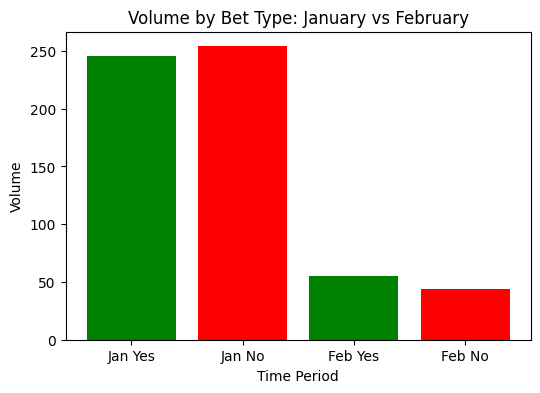

In [5]:
# Data for the bar chart
plt.figure(figsize=(6, 4))

periods = ['Jan Yes', 'Jan No', 'Feb Yes', 'Feb No']
volumes = [dec_jan_volume_no, dec_jan_volume_yes, feb_volume_no, feb_volume_yes]

# Create the bar chart
plt.bar(periods, volumes, color=['green', 'red'])

# Add labels and title
plt.xlabel('Time Period')
plt.ylabel('Volume')
plt.title('Volume by Bet Type: January vs February')

# Display the chart
plt.show()

In [6]:
dec_jan_median_no = dec_jan[(dec_jan['action'] == 'bought') & (dec_jan['type'] == "No")]['amount'].median() + dec_jan[(dec_jan['action'] == 'sold') & (dec_jan['type'] == "Yes")]['amount'].median()
dec_jan_median_yes = dec_jan[(dec_jan['action'] == 'bought') & (dec_jan['type'] == "Yes")]['amount'].median() + dec_jan[(dec_jan['action'] == 'sold') & (dec_jan['type'] == "No")]['amount'].median()
feb_median_no = feb[(feb['action'] == 'bought') & (feb['type'] == "No")]['amount'].median() + feb[(feb['action'] == 'sold') & (feb['type'] == "Yes")]['amount'].median()
feb_median_yes = feb[(feb['action'] == 'bought') & (feb['type'] == "Yes")]['amount'].median() + feb[(feb['action'] == 'sold') & (feb['type'] == "No")]['amount'].median()

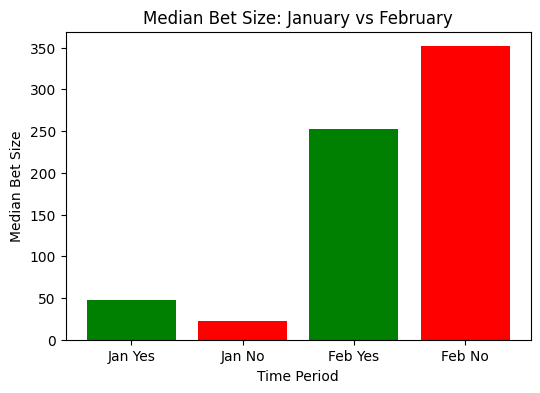

In [7]:
# Data for the bar chart
plt.figure(figsize=(6, 4))

periods = ['Jan Yes', 'Jan No', 'Feb Yes', 'Feb No']
medians = [dec_jan_median_no, dec_jan_median_yes, feb_median_no, feb_median_yes]

# Create the bar chart
plt.bar(periods, medians, color=['green', 'red'])

# Add labels and title
plt.xlabel('Time Period')
plt.ylabel('Median Bet Size')
plt.title('Median Bet Size: January vs February')

# Display the chart
plt.show()

In [8]:
dec_jan[(dec_jan['action'] == 'bought') & (dec_jan['type'] == "No")]['amount'].mean() + dec_jan[(dec_jan['action'] == 'sold') & (dec_jan['type'] == "Yes")]['amount'].mean()

np.float64(599.9277621680413)